In [1]:
# Code from https://github.com/xprathamesh/Spoiler-Detection-in-Movie-Reviews/blob/master/MaLSTM-Spoiler-Detection.ipynb

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os, datetime, argparse, csv, itertools, random
from sys import exit
import nltk, tensorflow

import pandas as pd
import numpy as np

from math import exp
from re import sub
from time import time
from random import shuffle

from gensim.models import KeyedVectors
from nltk.corpus import stopwords

import keras
import keras.backend as K

import matplotlib
import matplotlib.pyplot as plt
import tkinter

2023-05-08 03:59:25.189783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Concatenate, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
tensorflow.test.is_built_with_cuda()

True

In [6]:
# Unzip dataset https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset
# !unzip /content/drive/MyDrive/UNIST/deep-learning/imdb-spoiler-dataset.zip -d /content/data

In [7]:
# files
preprocessed_file = '/root/lstm/data/preprocessed.csv'
review_file = '/root/lstm/data/IMDB_reviews.json'
movie_file = '/root/lstm/data/IMDB_movie_details.json'
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
google_embeddings = '/root/lstm/GoogleNews-vectors-negative300.bin.gz'
ckpt_filepath = '/root/lstm/saved_models_manhtn/lr1-san-adam--{epoch:02d}-{val_loss:.5f}.hdf5'

# files in colab
# preprocessed_file = '/content/drive/MyDrive/UNIST/deep-learning/preprocessed.csv'
# review_file = '/content/data/IMDB_reviews.json'
# movie_file = '/content/data/IMDB_movie_details.json'
# # https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
# google_embeddings = '/content/drive/MyDrive/UNIST/deep-learning/GoogleNews-vectors-negative300.bin.gz'
# ckpt_filepath = '/content/drive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--{epoch:02d}-{val_loss:.5f}.hdf5'

In [8]:
# Load data
nltk.download('stopwords')
if not os.path.exists(preprocessed_file):
    review_data = pd.read_json(review_file, lines = True)
    review_data.head()
    movie_data = pd.read_json(movie_file, lines = True)
    movie_map = dict()
    # movie_list = movie_data.
    movie_synopses = pd.Series([str(synopsis) for synopsis in movie_data['plot_synopsis']])
    movie_summary = pd.Series([re.split('\s*Written by\s*\n', 
                                          str(plot))[0] for plot in movie_data['plot_summary']])
    movie_info = pd.Series([movie_synopses[i] \
                                        if len(movie_synopses[i]) > len(movie_summary[i]) else movie_summary[i] \
                                        for i in range(len(movie_synopses))])
    movie_ids = pd.Series(movie_data['movie_id'])
    movie_data.head()
    m_info = list(movie_info)
    m_ids = list(movie_ids)
    for minfo, mid in zip(m_info, m_ids):
        movie_map[str(mid)] = minfo
    tmp_list = list()
    for movie_id in list(review_data["movie_id"]):
        if movie_id not in movie_map:
            print(f"{movie_id} not in map")
            tmp_list.append("No synopsis")
            continue
        movie_info = movie_map[str(movie_id)]
        tmp_list.append(movie_info)
    input_data = pd.DataFrame({"review": review_data["review_text"], "synopsis": tmp_list, 'label': review_data["is_spoiler"]})
    input_data.to_csv(preprocessed_file, index=False)
    input_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# rows_count  = 300000
rows_count  = 600000
test_ratio  = 0.80 # divide into train and test data
train_ratio = 0.90 # divide into train and validation data
random_state = 200
max_len     = 30
vocab_size  = 1
vocab_limit = None

data_name     = 'movie_training'
sequence_cols = ['synopsis', 'review']
score_col     = ['label']

x_train, y_train  = list(), list()
x_val, y_val      = list(), list()
x_test, y_test    = list(), list()

vocab       = set('PAD')
word_to_id  = {'PAD':0}
id_to_word  = {0:'PAD'}

word_to_count = dict()
# Split data into train and test sets
# train_data, test_data, train_label, test_label = train_test_split(input_data, label, test_size=0.2, random_state=42)

In [10]:
data_df = pd.read_csv(preprocessed_file, nrows=rows_count)
data_df = data_df.sample(frac=0.18, random_state=random_state)
print(f"len: {len(data_df)}")
data_df.head()

len: 103304


,review,synopsis,label
236704,Once again Fake Crap Hollywood makes a movie w...,"In the year 2007, young Reed Richards does a p...",True
450968,I feel that this is a worthwhile film that has...,Slumdog Millionaire is the story of Jamal Mali...,True
363097,The Aviator is below many films that Martin Sc...,The Aviator has no opening credits other than ...,False
275056,"As an old fan of the comics, I have to say tha...","In Congress, Senator Robert Kelly attempts to ...",False
204606,i cannot easily compose all my thoughts and fe...,The third Hobbit film picks up shortly after t...,True


In [11]:
def text_to_word_list(text):
  ''' Pre process and convert texts to a list of words '''
  text = str(text)
  text = text.lower()

  # Clean the text
  text = sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = sub(r"what's", "what is ", text)
  text = sub(r"\'s", " ", text)
  text = sub(r"\'ve", " have ", text)
  text = sub(r"can't", "cannot ", text)
  text = sub(r"n't", " not ", text)
  text = sub(r"i'm", "i am ", text)
  text = sub(r"\'re", " are ", text)
  text = sub(r"\'d", " would ", text)
  text = sub(r"\'ll", " will ", text)
  text = sub(r",", " ", text)
  text = sub(r"\.", " ", text)
  text = sub(r"!", " ! ", text)
  text = sub(r"\/", " ", text)
  text = sub(r"\^", " ^ ", text)
  text = sub(r"\+", " + ", text)
  text = sub(r"\-", " - ", text)
  text = sub(r"\=", " = ", text)
  text = sub(r"'", " ", text)
  text = sub(r"(\d+)(k)", r"\g<1>000", text)
  text = sub(r":", " : ", text)
  text = sub(r" e g ", " eg ", text)
  text = sub(r" b g ", " bg ", text)
  text = sub(r" u s ", " american ", text)
  text = sub(r"\0s", "0", text)
  text = sub(r" 9 11 ", "911", text)
  text = sub(r"e - mail", "email", text)
  text = sub(r"j k", "jk", text)
  text = sub(r"\s{2,}", " ", text)

  text = text.split()

  return text

In [12]:
def generate_vocab():
  print('Generating vocabulary')

  global vocab_size, vocab
  global word_to_id, id_to_word, word_to_count
  global data_df

  stops = set(stopwords.words('english'))

  # Iterate over required sequences of provided dataset
  for index, row in data_df.iterrows():
      # Iterate through the text of both questions of the row
      for col in sequence_cols:
          s2n = []  # Sequences with words replaces with indices
          for word in text_to_word_list(row[col]):
              # Remove unwanted words
              if word in stops:
                  continue

              if word not in vocab:
                  vocab.add(word)
                  word_to_id[word] = vocab_size
                  word_to_count[word] = 1
                  s2n.append(vocab_size)
                  id_to_word[vocab_size] = word
                  vocab_size += 1

              else:
                  word_to_count[word] += 1
                  s2n.append(word_to_id[word])

          # Replace |sequence as word| with |sequence as number| representation
          data_df.at[index, col] = s2n

In [13]:
start = time()
generate_vocab()
data_df.head()
print(f"Gen {vocab_size} vocab in {(time() - start) / 60} min")

Generating vocabulary
Gen vocab in 3.770389215151469 min


In [14]:
def preprocess_data():
  print('Building training data set')
  
  global x_train, x_val, y_train, y_val
  global x_test, y_test

  data_size = len(data_df)  

  X = data_df[sequence_cols]
  Y = data_df[score_col]

  x_rem, x_test, y_rem, y_test = train_test_split(X, Y, train_size=test_ratio, stratify=Y, random_state=random_state)
  x_train, x_val, y_train, y_val = train_test_split(x_rem, y_rem, train_size=train_ratio, stratify=y_rem, random_state=random_state)

  # Split to lists
  x_train = [x_train[column] for column in sequence_cols]
  x_val = [x_val[column] for column in sequence_cols]
  x_test = [x_test[column] for column in sequence_cols]

  # Convert labels to their numpy representations
  y_train = y_train.values
  y_val = y_val.values
  y_test = y_test.values

In [15]:
preprocess_data()
print('Length X_train: ' + str(len(x_train[0])))
print('Length X_val: ' + str(len(x_val[0])))
print('Length X_test: ' + str(len(x_test[0])))

Building training data set
Length X_train: 74378
Length X_val: 8265
Length X_test: 20661


In [16]:
max_len = 1024
def pad_seq():
  print('Padding sequences')

  global max_len

  if max_len == 0:
      max_len = max(
          max(len(seq) for seq in x_train[0]),
          max(len(seq) for seq in x_train[1]),
          max(len(seq) for seq in x_val[0]),
          max(len(seq) for seq in x_val[1]),
          max(len(seq) for seq in x_test[0]),
          max(len(seq) for seq in x_test[1]))
  print(f"max_len: {max_len}")
  # Zero padding
  for dataset, side in itertools.product([x_train, x_val, x_test], [0, 1]):
      if max_len: dataset[side] = pad_sequences(dataset[side], maxlen=max_len)
      else : dataset[side] = pad_sequences(dataset[side])

In [17]:
print(f"Review seq len: {np.mean([len(seq) for seq in x_train[1]])}")
print(f"Synopsis seq len: {np.mean([len(seq) for seq in x_train[0]])}")
max_len_tmp = max(
          max(len(seq) for seq in x_train[0]),
          max(len(seq) for seq in x_train[1]),
          max(len(seq) for seq in x_val[0]),
          max(len(seq) for seq in x_val[1]),
          max(len(seq) for seq in x_test[0]),
          max(len(seq) for seq in x_test[1]))
print(f"max seq len: {max_len_tmp}")
pad_seq()

Review seq len: 139.51324316330098
Synopsis seq len: 1011.2758745865713
max seq len: 5998
Padding sequences
max_len: 1024


In [18]:
from gensim.models import KeyedVectors

In [19]:
embedding_dim = 300

def get_embedding_matrix(word_index):
  word2vec = KeyedVectors.load_word2vec_format(google_embeddings, binary=True)

  # Prepare Embedding Matrix.
  embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))

  for word, i in word_index.items():
  # words not found in embedding index will be all-zeros.
    if word not in word2vec.key_to_index:
      continue
    embedding_matrix[i] = word2vec.get_vector(word)

  del word2vec
  return embedding_matrix

In [20]:
print('Building Embedding Matrix')
embedding_matrix = get_embedding_matrix(word_to_id)
embedding_size = embedding_matrix.shape[1]

Building Embedding Matrix


## Manhatten LSTM

In [40]:
hidden_size = 50
adadel_learning_rate = 0.66
adam_learning_rate = 1e-4 # 0.001
# dropout_rate = 0.1
batch_size = 64
num_epochs = 30 # number of epochs

PATIENCE = 4
VERBOSE = 1

In [41]:
print('Number of training samples        :', len(x_train[0]))
print('Number of validation samples      :', len(x_val[0]))
print('Number of testing samples         :', len(x_test[0]))
print('Maximum sequence length           :', max_len)

Number of training samples        : 74378
Number of validation samples      : 8265
Number of testing samples         : 20661
Maximum sequence length           : 1024


In [42]:
def exponent_neg_manhattan_distance(x, hidden_size=50):
  ''' Helper function for the similarity estimate of the LSTMs outputs '''
  return K.exp(-K.sum(K.abs(x[:,:hidden_size] - x[:,hidden_size:]), axis=1, keepdims=True))

def exponent_neg_cosine_distance(x, hidden_size=50):
  ''' Helper function for the similarity estimate of the LSTMs outputs '''
  leftNorm = K.l2_normalize(x[:,:hidden_size], axis=-1)
  rightNorm = K.l2_normalize(x[:,hidden_size:], axis=-1)
  return K.exp(K.sum(K.prod([leftNorm, rightNorm], axis=0), axis=1, keepdims=True))

In [43]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    # return 2 * prec * rec / (prec + rec + K.epsilon())
    return y_true

In [44]:
# opt1 = keras.optimizers.Adadelta(lr=adadel_learning_rate, clipnorm=1.25)
adam_opt = keras.optimizers.Adam(lr=adam_learning_rate)

checkpoint = ModelCheckpoint(filepath=ckpt_filepath, 
                             monitor='val_loss', 
                             verbose=VERBOSE,
                             save_best_only=True, 
                             mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=PATIENCE,
                               verbose=VERBOSE)

/root/lstm/.conda/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
from tensorflow.keras.layers import concatenate

In [46]:
def get_manhattan_lstm_model(embedding_matrix, embedding_size, lstm_layers, opt):
  embed_layer = Embedding(output_dim=embedding_size, input_dim=vocab_size+1, input_length=max_len, trainable=False)
  embed_layer.build((None,))
  embed_layer.set_weights([embedding_matrix])

  seq_1 = Input(shape=(max_len,), dtype='int32', name='sentence_1')
  seq_2 = Input(shape=(max_len,), dtype='int32', name='sentence_2')

  input_1 = embed_layer(seq_1)
  input_2 = embed_layer(seq_2)

  l1 = LSTM(units=hidden_size)

  l1_out = l1(input_1)
  l2_out = l1(input_2)

  concats = concatenate([l1_out, l2_out], axis=-1)

  main_output = Lambda(exponent_neg_manhattan_distance, output_shape=(1,))(concats)
  model = Model(inputs=[seq_1, seq_2], outputs=[main_output])

  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1])
  return model

In [47]:
man_lstm_model = get_manhattan_lstm_model(embedding_matrix, embedding_size, hidden_size, adam_opt)
man_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_1 (InputLayer)        [(None, 1024)]       0           []                               
                                                                                                  
 sentence_2 (InputLayer)        [(None, 1024)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1024, 300)    42021000    ['sentence_1[0][0]',             
                                                                  'sentence_2[0][0]']             
                                                                                                  
 lstm_1 (LSTM)                  (None, 50)           70200       ['embedding_1[0][0]',      

In [48]:
training_start_time = time()
man_lstm_model_ = man_lstm_model.fit(x_train, 
                                 y_train, 
                                 validation_data=(x_val, y_val),
                                 epochs=num_epochs,
                                 callbacks=[checkpoint, early_stopping], 
                                 batch_size=batch_size, 
                                 verbose=1)

print("Training time finished.\n{} epochs in {}".format(num_epochs, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/30
1163/1163 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7361 - f1: 0.2637
Epoch 1: val_loss improved from inf to 0.53655, saving model to /root/lstm/saved_models_manhtn/lr1-san-adam--01-0.53655.hdf5
1163/1163 [==============================] - 79s 66ms/step - loss: 0.5793 - accuracy: 0.7361 - f1: 0.2637 - val_loss: 0.5365 - val_accuracy: 0.7350 - val_f1: 0.2638
Epoch 2/30
1163/1163 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.7405 - f1: 0.2637
Epoch 2: val_loss improved from 0.53655 to 0.51648, saving model to /root/lstm/saved_models_manhtn/lr1-san-adam--02-0.51648.hdf5
1163/1163 [==============================] - 76s 65ms/step - loss: 0.5242 - accuracy: 0.7405 - f1: 0.2637 - val_loss: 0.5165 - val_accuracy: 0.7425 - val_f1: 0.2638
Epoch 3/30
1163/1163 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.7555 - f1: 0.2637
Epoch 3: val_loss improved from 0.51648 to 0.50282, saving model to /root/lstm/save

In [58]:
# stratified model
model_path = '/root/lstm/saved_models_manhtn-1024/lr1-san-adam--27-0.49729.hdf5'

man_lstm_model.load_weights(model_path)

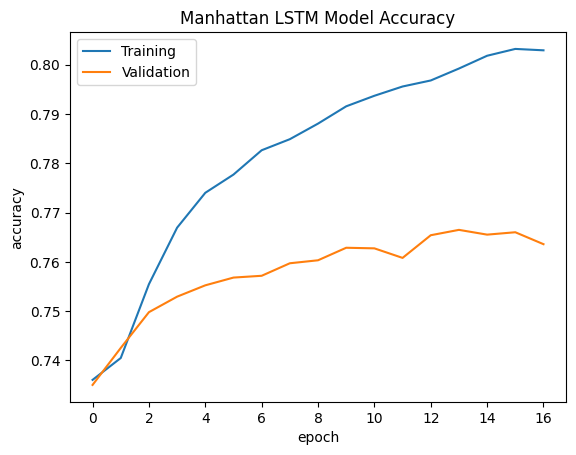

In [59]:
plt.figure(1)
plt.plot(man_lstm_model_.history['accuracy'])
plt.plot(man_lstm_model_.history['val_accuracy'])
plt.title('Manhattan LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

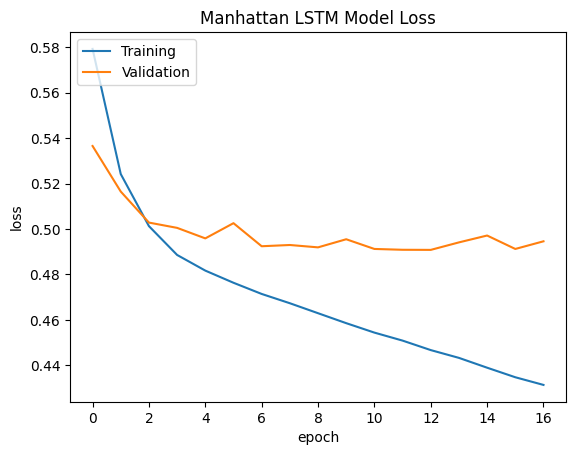

In [60]:
plt.figure(2)
plt.plot(man_lstm_model_.history['loss'])
plt.plot(man_lstm_model_.history['val_loss'])
plt.title('Manhattan LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

In [61]:
score = man_lstm_model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

323/323 [==============================] - 10s 29ms/step - loss: 0.5052 - accuracy: 0.7485 - f1: 0.2637
Test loss: 0.5051814913749695
Test accuracy: 0.7484632730484009


In [62]:
from sklearn.metrics import classification_report

In [66]:
y_pred = man_lstm_model.predict(x_test)
y_pred_1hot = [0 if x < 0.4 else 1 for x in y_pred]
y_test_1hot = [0 if not x else 1 for x in y_test]
print(classification_report(y_test_1hot, y_pred_1hot))

646/646 [==============================] - 19s 29ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     15212
           1       0.51      0.45      0.47      5449

    accuracy                           0.74     20661
   macro avg       0.66      0.64      0.65     20661
weighted avg       0.73      0.74      0.73     20661



In [73]:
y_pred_1hot = [0 if x < 0.5 else 1 for x in y_pred]
print("0.5")
print(classification_report(y_test_1hot, y_pred_1hot))
y_pred_1hot = [0 if x < 0.45 else 1 for x in y_pred]
print("0.45")
print(classification_report(y_test_1hot, y_pred_1hot))
y_pred_1hot = [0 if x < 0.37 else 1 for x in y_pred]
print("0.37")
print(classification_report(y_test_1hot, y_pred_1hot))
y_pred_1hot = [0 if x < 0.35 else 1 for x in y_pred]
print("0.35")
print(classification_report(y_test_1hot, y_pred_1hot))
y_pred_1hot = [0 if x < 0.33 else 1 for x in y_pred]
print("0.33")
print(classification_report(y_test_1hot, y_pred_1hot))

0.5
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     15212
           1       0.57      0.19      0.28      5449

    accuracy                           0.75     20661
   macro avg       0.67      0.57      0.56     20661
weighted avg       0.71      0.75      0.70     20661

0.45
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     15212
           1       0.54      0.31      0.40      5449

    accuracy                           0.75     20661
   macro avg       0.66      0.61      0.62     20661
weighted avg       0.72      0.75      0.72     20661

0.37
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     15212
           1       0.49      0.52      0.51      5449

    accuracy                           0.73     20661
   macro avg       0.66      0.66      0.66     20661
weighted avg       0.74      0.73      0.73     20661

0.35


In [56]:
def word_to_sequence(tokens: list) -> list:
  result = list()
  stops = set(stopwords.words('english'))
  for token in tokens:
    if token in stops:
      continue
    if token in vocab:
      result.append(word_to_id[token])
  return result

def get_spoiler_prob(synopsis, review) -> float:
  #pd.DataFrame({'synopsis': [synopsis], 'review': [review]})
  # print('synop')
  s_tokens = text_to_word_list(synopsis)
  s_seq = pad_sequences([word_to_sequence(s_tokens)], maxlen=max_len)
  # print('review')
  r_tokens = text_to_word_list(review)
  r_seq = pad_sequences([word_to_sequence(r_tokens)], maxlen=max_len)
  y_pred = man_lstm_model.predict([s_seq, r_seq])
  return y_pred[0]

In [57]:
def test_spoiler():
  synopsis = "Jack Ryan (Ford) is on a \"working vacation\" in London with his family. He has retired from the CIA and is a Professor at the US Naval Academy. He is seen delivering a lecture at the Royal Naval Academy in London.Meanwhile, Ryan's wife Cathy and daughter Sally are sightseeing near Buckingham Palace. Sally and Cathy come upon a British Royal Guard, and Sally tries to get the guard to react by doing an improvised tap dance in front of him. She's impressed when the guard, trained to ignore distraction, doesn't react at all, and they leave.As Sally and Cathy walk away from the guard, en route to rendezvous with Ryan, they walk by a stolen cab, in which sit three Ulster Liberation Army terrorists: Kevin O'Donnell, the driver, as well as Sean Miller (Sean Bean) and his younger brother Patrick. The three are loading bullets into their guns as they prepare to carry out a scheduled ambush on Lord William Holmes, British Secretary of State for Northern Ireland and a distant member of the British Royal Family (the cousin of the Queen Mother). As they finish loading their weapons, another terrorist, Annette, radios to them that Lord Holmes is leaving the palace with his wife and son.As Lord Holmes's car leaves the palace, the terrorists' car falls in line behind him. They follow the car, headed for the ambush point. As they drive, O'Donnell and the Miller brothers don ski masks.Meanwhile, Ryan is about to cross the street to meet with his wife and daughter. He arrives at the same time that Lord Holmes's car is passing through the area.Suddenly, another cab, parked on the side of the road, driven by Annette, pulls out and swerves in front of Lord Holmes's vehicle. Simultaneously, O'Donnell's vehicle swerves to a stop behind the car. The Millers and another accomplice jump out and quickly plant a bomb underneath the chauffeured car's engine. Ryan sees what's going on and hastily gets his family to cover just as the bomb is detonated. Moments later, Sean and another accomplice begin shooting into the car, riddling Lord Holmes's driver and bodyguard with bullet. The onslaught of bullets does not kill Lord Holmes, who is currently using his body to shield his family. Sean marches over to the rear door and orders Lord Holmes out of the car at gunpoint. Ryan, unable to stand being just a bystander, immediately breaks cover, runs up behind Miller, and disarms him. As Ryan grabs Sean's pistol, he gets shot in the left shoulder by another terrorist. He shoots one of the other terrorists in the shoulder. Patrick attempts to flee, but Ryan fatally shoots him in the chest. Seeing two of the royal guards racing towards the scene, the remaining terrorists quickly get back in their cars and drive off, leaving Sean to be captured when the authorities arrive. They retreat back to a warehouse, where they change out license plates.While recovering, Ryan is called to testify against Miller as a witness. Subsequently, Miller is convicted on all charges and sentenced to life in prison. Ryan is awarded the order of Knight Commander of the Victorian Order, and eventually returns to the United States.On the possibility that Miller's ULA comrades might try to liberate him, the authorities take no chances. To that extent, they set up decoy convoys on the day that Miller is to be transferred to Albany Prison on the Isle of Wight. However, someone manages to tip off the ULA as to which convoy is carrying Miller. Miller's motorcade is in transit when it comes to a stop at a drawbridge. The raised bridge, however, is a trap meant to block them in. Moments after the convoy comes to a stop, Miller's comrades attack, using rocket launchers to blow up the cars at the front and rear of the convoy. They then march up to the prison van and order the guards out at gunpoint by taking the bridge operator hostage and threatening to shoot him. One of the guards hesitates and is shot fatally. The other officer and the inspector are pulled out, thrown on the ground and forced to lie on their stomachs. O'Donnell hands Miller a pistol, with which he coldly executes both officers and the bridge operator by shooting them in the backs of their heads. They then depart the scene.Miller and his companions flee on a cargo ship from Britain to Libya, to prepare for their next kidnapping attempt on Lord Holmes. Miller however, cannot shake his anger towards Ryan for killing his younger brother and persuades several members of his entourage to accompany him to the United States on a short mission targeting Ryan and his family.Miller travels to the United States, accompanied by Annette, comrade Ned Clark, and a fourth henchman. Annette and Clark travel to the United States Naval Academy to ambush Ryan as he's leaving work. Ryan notices Clark idling nearby. Clark casually walks away, but Ryan clearly unnerved, then gets even more nervous as he hears a car engine starting. His suspicions are well warranted-as he continues walking down the street, he looks in the reflection of a parked van's rearview door and sees that Clark, and the stolen car driven by Annette, are following him. Ryan pretends not to see them until he's walking past a parked panel truck, at which point he ducks behind the truck. Clark draws a silenced pistol and prepares to corner Ryan, but Ryan attacks him first. Clark quickly gets the upper hand and throws Ryan to the curb. He grabs his pistol and is about to shoot Ryan when he's shot dead himself by a US Marine sentry. Annette quickly drives away in her Jeep. Ryan, realizing that Miller is going to target Cathy and Sally, jumps into his car and drives off.Simultaneously, Miller and the other henchman follow Cathy as she picks up Sally from school, with Miller riding shotgun. They prepare to follow the two, but are temporarily held up by a crossing guard. Once the crossing guard clears, they pursue her to US Highway 50. Ryan tries to frantically call Cathy on his car phone, but she is busy answering phone calls from the hospital. As he's trying to connect with her, Miller and his henchman recklessly weave in and out of traffic to catch up with Cathy. Ryan eventually gets through to Cathy and tells her to get off the highway and find the nearest police station. Unfortunately, just as the call ends, Miller's van comes charging up on her using the left shoulder. Miller moves to the backseat of the van, grabs a submachine gun, and slides open the door. Another car momentarily delays him, but once he has a clear aim, Miller opens fire, spraying Cathy's car with bullets. A multicar pileup ensues as Cathy loses control of her car and crashes head-on into a concrete barrier. Ryan, who has found himself stuck in traffic headed in the other direction, sees the smoke from the crash and realizes the worst.Cathy and Sally are airlifted to a nearby hospital for treatment. Enraged over the near-loss of his family, Ryan decides to go back to work for the CIA, having earlier rejected the appeal of his former superior, Vice Admiral James Greer (James Earl Jones).Ryan's tireless work leads him to conclude that Miller has taken refuge in a training camp, one of many located in Libya. He also determines that a recent new arrival at the camp may be one of O'Donnell's English informants, Dennis Cooley. Ryan makes his recommendations to his superiors at the CIA. Greer invites Jack to a live feed of an SAS strike team attack on the camp. Everyone in the camp is eliminated but unbeknownst to the CIA and Ryan, Miller and his companions have already fled the camp and are on their way to the US to stage their next attack on Lord Holmes.Lord Holmes decides to visit Ryan at his home to formally present his KCVO. With the aid of Lord Holmes' traitorous assistant, Miller's group tracks Holmes to this location, kills the Diplomatic Security Service agents and Maryland state troopers guarding the house, and attempts once more to kidnap Lord Holmes. Ryan leads Holmes and his family to safety while he attempts to lure Miller and his companions away from his home.The FBI Hostage Rescue Teams are scrambled to pick up Holmes. Upon realising that Ryan is leading them away from Holmes, Miller's companions try to persuade Miller to turn around, but an enraged and deranged Miller kills his terrorist companions and continues his pursuit of Ryan. Ryan and Miller fight hand to hand; Miller is killed when Ryan impales him backward on a boat anchor, and his body is obliterated in the subsequent explosion of the craft.Credits roll just after Caroline Ryan learns the gender of the child she is going to have, and before she tells Jack and Sally."
  review = "Sally and Jack are both alive in the end."
  prob = get_spoiler_prob(synopsis, review)
  print(f"synopsis: {synopsis}")
  print(f"review: {review}")
  print(f"prob: {prob}")

test_spoiler()

1/1 [==============================] - 0s 67ms/step
synopsis: Jack Ryan (Ford) is on a "working vacation" in London with his family. He has retired from the CIA and is a Professor at the US Naval Academy. He is seen delivering a lecture at the Royal Naval Academy in London.Meanwhile, Ryan's wife Cathy and daughter Sally are sightseeing near Buckingham Palace. Sally and Cathy come upon a British Royal Guard, and Sally tries to get the guard to react by doing an improvised tap dance in front of him. She's impressed when the guard, trained to ignore distraction, doesn't react at all, and they leave.As Sally and Cathy walk away from the guard, en route to rendezvous with Ryan, they walk by a stolen cab, in which sit three Ulster Liberation Army terrorists: Kevin O'Donnell, the driver, as well as Sean Miller (Sean Bean) and his younger brother Patrick. The three are loading bullets into their guns as they prepare to carry out a scheduled ambush on Lord William Holmes, British Secretary of S

In [74]:
vocab_size

140069